In [1]:
import numpy as np
from Meshing.Meshing import *
from Fields.Fields import *
from Kernels.Kernels import *
from Solvers.Solvers import *
from Subchannel.FluidRelation import FluidRelation
from Subchannel.Channel import Channel
from Subchannel.Channel import ChannelInterface



In [ ]:
gravity = 9.81
Dh = 0.0158276279311347000000
perim = 0.07267978843558340
area = 0.000287587162368000000
temp_tolerance = 1e-10
max_temp_iterations = 1000
nZones=50
L0 = 0.0
L1 = 1.74
fluid = FluidRelation(cp=1983, mu=0.00744, k=1.44, rho_0 = 2715.13, drho_dT=-0.513)
pressure_bc = 0.0
T_bc = 900.0
mdot_bc = 0.12292778 # Set to have a 9.1725 second residence time in the main core.
fric = 'type1'
_dt = 1e321
heat_source = [0.0]*nZones # heat source in W/m3
#################
# CHANNEL SETUPS
#################
ch = Channel(gravity=gravity,
             Dh=Dh,
             area=area,
             temp_tolerance=temp_tolerance,
             max_temp_iterations=max_temp_iterations,
             nZones=nZones,
             L0=L0,
             L1=L1,
             fluid=fluid,
             pressure_bc=pressure_bc,
             T_bc=T_bc,
             mdot_bc=mdot_bc,
             fric=fric,
             heat_source=heat_source)

upper_plenum = Channel(gravity=gravity,
                       Dh=Dh,
                       area=1.5424651E-04,
                       temp_tolerance=temp_tolerance,
                       max_temp_iterations=max_temp_iterations,
                       nZones=nZones,
                       L0=0.0,
                       L1=1.0,
                       fluid=fluid,
                       pressure_bc=pressure_bc,
                       T_bc=1.0,
                       mdot_bc=1.0,
                       fric='none',
                       heat_source=0.0)

external_loop = Channel(gravity=gravity,
                       Dh=Dh,
                       area=1.0005305523E-03,
                       temp_tolerance=temp_tolerance,
                       max_temp_iterations=max_temp_iterations,
                       nZones=nZones,
                       L0=0.0,
                       L1=1.0,
                       fluid=fluid,
                       pressure_bc=pressure_bc,
                       T_bc=1.0,
                       mdot_bc=1.0,
                       fric='none',
                       heat_source=0.0)

lower_plenum = Channel(gravity=gravity,
                       Dh=Dh,
                       area=2.20816E-04,
                       temp_tolerance=temp_tolerance,
                       max_temp_iterations=max_temp_iterations,
                       nZones=nZones,
                       L0=0.0,
                       L1=1.0,
                       fluid=fluid,
                       pressure_bc=pressure_bc,
                       T_bc=1.0,
                       mdot_bc=1.0,
                       fric='none',
                       heat_source=0.0)

# Interfaces to handle data passing from one channel to another.
ch_to_up = ChannelInterface(ch1=ch, ch2=upper_plenum)
up_to_ex = ChannelInterface(ch1=upper_plenum, ch2=external_loop)
ex_to_lp = ChannelInterface(ch1=external_loop, ch2=ch)
lp_to_ch = ChannelInterface(ch1=lower_plenum, ch2=ch)

# Solution order - main channel -> plenum -> external loop -> lower plenum -> main channel
ch.solve_channel_TH(_dt=_dt)
ch_to_up.update_interface_conditions(tracer_bool=False, th_bool=True)

upper_plenum.solve_channel_TH(_dt=_dt)
up_to_ex.update_interface_conditions(tracer_bool=False, th_bool=True)

external_loop.solve_channel_TH(_dt=_dt)
ex_to_lp.update_interface_conditions(tracer_bool=False, th_bool=True)

lower_plenum.solve_channel_TH(_dt=_dt)
lp_to_ch.update_interface_conditions(tracer_bool=False, th_bool=True)

# End



Channel solved after 1 iterations!
Channel solved after 2 iterations!
Channel solved after 2 iterations!


In [ ]:
tracer_names = ['c1', 'c2', 'c3', 'c4', 'c5', 'c6']
initial_value_tracers = 0.0
scheme_tracers = 'upwind'
decay_consts = [0.0001, 0.10, 0.15, 0.20, 0.25, 0.30]
beta = [1.0,1.0,1.0,1.0,1.0,1.0]
boundary = 'lower' # must be lower anyways
phi_tracer = 1.0
rho_tracer = 1.0
fsrc = np.sin(np.pi * np.array(ch.mesh.centroids) / L1)

# TRACER SETUP IN MAIN CHANNEL
for idx, name in enumerate(tracer_names):
  ch.add_tracer_to_channel(name=tracer_names[idx], initial_value=initial_value_tracers,
                          scheme='upwind', decay_const=decay_consts[idx],
                          boundary=boundary, phi=phi_tracer, rho=rho_tracer, source=fsrc, beta=beta[idx])

# TRACER SETUP IN UPPER PLENUM
for idx, name in enumerate(tracer_names):
  upper_plenum.add_tracer_to_channel(name=tracer_names[idx], initial_value=0.0,
                                     scheme='upwind', decay_const=decay_consts[idx],
                                     boundary=boundary, phi=phi_tracer,rho=rho_tracer,source=0.0, beta=beta[idx])

# TRACER SETUP IN EXTERNAL LOOP
for idx, name in enumerate(tracer_names):
  external_loop.add_tracer_to_channel(name=tracer_names[idx], initial_value=0.0,
                                     scheme='upwind', decay_const=decay_consts[idx],
                                     boundary=boundary, phi=phi_tracer,rho=rho_tracer,source=0.0, beta=beta[idx])

# TRACER SOLVE LOOP
ch_inlet_value = phi_tracer
while True:
  ch.solve_all_tracers(_dt=1e321)
  ch_to_up.update_interface_conditions(tracer_bool=True, th_bool=False)

  upper_plenum.solve_all_tracers(_dt=1e321)
  up_to_ex.update_interface_conditions(tracer_bool=True, th_bool=False)

  external_loop.solve_all_tracers(_dt=1e321)
  ex_to_lp.update_interface_conditions(tracer_bool=True, th_bool=False)

  lower_plenum.solve_all_tracers(_dt=1e321)
  lp_to_ch.update_interface_conditions(tracer_bool=True,th_bool=False)

  diff = np.abs(ch_inlet_value - ch.tracers['c1'].T[0])
  print(diff)
  ch_inlet_value = ch.tracers['c1'].T[0]
  if diff < 1e-12:
    break




0.018850390785208226
3.666048905884036
2.954137449432957
2.3804723543473383
1.9182075061875246
1.545710047871152
1.2455480152084437
1.0036745638849904
0.8087706117223643
0.6517151334929423
0.5251583193894582
0.4231776220168939
0.3410005957519324
0.27478155803455806
0.22142162089016892
0.17842367059968822
0.14377550892399782
0.11585568717917027
0.09335762642896483
0.07522847280660017
0.06061982654541609
0.048848038957821416
0.03936221935967055
0.03171845474196644
0.02555903573490781
0.020595716689626897
0.016596226491447652
0.01337339884334554
0.010776413344061098
0.008683737464359353
0.00699743912400308
0.005638603711279444
0.004543641073400551
0.003661309654177103
0.0029503185148485045
0.002377395020154438
0.0019157277607000367
0.0015437118451231413
0.0012439378442188342
0.0010023770726448333
0.0008077250807829728
0.0006508726346048377
0.0005244794256853424
0.00042263056297997537
0.00034055977030078566
0.00027442633663099514
0.00022113538006607314
0.0001781930150244193
0.0001435896444

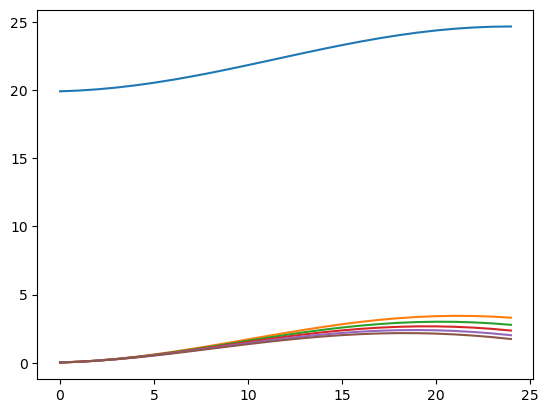

In [30]:
for this in ch.tracers.keys():
  plt.plot(ch.tracers[this].T)

In [5]:
### ADDED THESE TO TO CHANNEL CODE - NOW NEED TO INCORPORATE PASSING OF OUTGOING VALUES INTO CHANNEL.PY
### IN GET_OUTLET_CONDITIONS() - AND - UPDATE_INTERFACE_CONDITIONS() SO THAT TRACERS ARE HANDLED SEAMLESSLY.
# DNP EQUATION
c1 = ScalarField(name='c1', initial_value=0.0, mesh=ch.mesh)

# KERNELS
c1_adv = AdvectionKernel(field=c1, mesh=ch.mesh, w=ch.velocity_faces, scheme='quick', rho=1.0)
c1_decay = ImplicitReactionKernel(field=c1, mesh=ch.mesh,lam=0.05)

# BCS
bc = AdvectedInletFluxBC(field=c1, mesh=ch.mesh, boundary='lower', phi=1.0, w=ch.velocity_faces, rho=1.0)

# SOLVER
solver = BasicSolver(kernels=[c1_decay, c1_adv], bcs=[bc], field=c1)
solver.solve()

print(c1.T)


[0.98918387 0.97836738 0.96438001 0.95008421 0.93592148 0.92195763
 0.90820022 0.89464781 0.88129756 0.86814658 0.85519172 0.84243045
 0.82985901 0.81747646 0.80527586 0.7932635  0.78141691 0.76977649
 0.7582457  0.74702668 0.73567046 0.72514787 0.71333418 0.7048542
 0.68961642]


In [6]:
ch.velocity_faces.T

array([0.23146093, 0.23146093, 0.23146093, 0.23146093, 0.23146093,
       0.23146093, 0.23146093, 0.23146093, 0.23146093, 0.23146093,
       0.23146093, 0.23146093, 0.23146093, 0.23146093, 0.23146093,
       0.23146093, 0.23146093, 0.23146093, 0.23146093, 0.23146093,
       0.23146093, 0.23146093, 0.23146093, 0.23146093, 0.23146093,
       0.23146093])

In [7]:
ch.temp.T

array([900., 900., 900., 900., 900., 900., 900., 900., 900., 900., 900.,
       900., 900., 900., 900., 900., 900., 900., 900., 900., 900., 900.,
       900., 900., 900.])

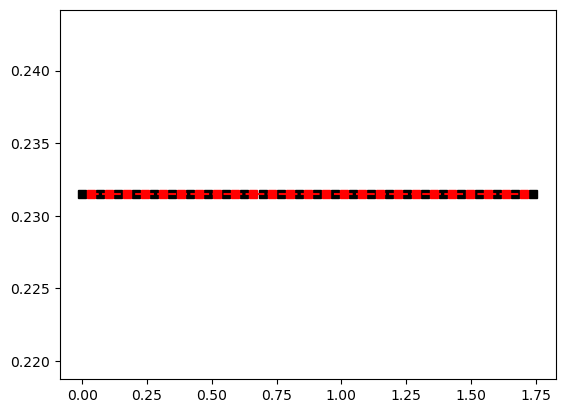

In [8]:
# velocities at faces and at centroids
plt.plot(ch.mesh.nodeCoords, ch.velocity_faces.T, 'k--s')
plt.plot(ch.mesh.centroids, ch.mdot.T / ch.rho.T / ch.area, 'r--s')

In [9]:
external_loop.temp.T

array([900., 900., 900., 900., 900., 900., 900., 900., 900., 900., 900.,
       900., 900., 900., 900., 900., 900., 900., 900., 900., 900., 900.,
       900., 900., 900.])

In [10]:
ch.T_bc

np.float64(899.9999999999997)

In [11]:
ch.b_energy

array([3846336.20689655,       0.        ,       0.        ,
             0.        ,       0.        ,       0.        ,
             0.        ,       0.        ,       0.        ,
             0.        ,       0.        ,       0.        ,
             0.        ,       0.        ,       0.        ,
             0.        ,       0.        ,       0.        ,
             0.        ,       0.        ,       0.        ,
             0.        ,       0.        ,       0.        ,
             0.        ])

In [12]:
ch.temp.T

array([900., 900., 900., 900., 900., 900., 900., 900., 900., 900., 900.,
       900., 900., 900., 900., 900., 900., 900., 900., 900., 900., 900.,
       900., 900., 900.])

In [13]:
np.pi * Dh**2 / 4

0.00019675308308032713

In [14]:
0.18*area*2200

0.113884516297728

In [15]:
ch.heat_source

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [16]:
ch.h.T

array([1784700., 1784700., 1784700., 1784700., 1784700., 1784700.,
       1784700., 1784700., 1784700., 1784700., 1784700., 1784700.,
       1784700., 1784700., 1784700., 1784700., 1784700., 1784700.,
       1784700., 1784700., 1784700., 1784700., 1784700., 1784700.,
       1784700.])

In [17]:
ch.h_bc

np.float64(1784699.9999999993)